In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn.init as init
import tqdm
import sys
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

REAL = 1.
FAKE = 0.

In [ ]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=110, out_features=384*4*4),
            nn.ReLU(inplace=True),

            Reshape((-1, 384, 4, 4)),

            nn.ConvTranspose2d(in_channels=384, out_channels=192, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=192, out_channels=96, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(self.init_weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.model(x)

    def init_weights(self, m):
      if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.normal_(m.weight, mean=0, std=0.02)
        if m.bias is not None:
            init.zeros_(m.bias)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.relu1 = nn.LeakyReLU(0.2)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU(0.2)
        self.dropout3 = nn.Dropout(0.5)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.relu4 = nn.LeakyReLU(0.2)
        self.dropout4 = nn.Dropout(0.5)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.batch_norm5 = nn.BatchNorm2d(256)
        self.relu5 = nn.LeakyReLU(0.2)
        self.dropout5 = nn.Dropout(0.5)

        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm6 = nn.BatchNorm2d(512)
        self.relu6 = nn.LeakyReLU(0.2)
        self.dropout6 = nn.Dropout(0.5)

        self.discriminator = nn.Linear(512 * 4 * 4, 1)
        self.classifier = nn.Linear(512 * 4 * 4, 10)

        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

        self.apply(self.init_weights)


    def forward(self, x):
        x = self.dropout1(self.relu1(self.conv1(x)))
        x = self.dropout2(self.relu2(self.batch_norm2(self.conv2(x))))
        x = self.dropout3(self.relu3(self.batch_norm3(self.conv3(x))))
        x = self.dropout4(self.relu4(self.batch_norm4(self.conv4(x))))
        x = self.dropout5(self.relu5(self.batch_norm5(self.conv5(x))))
        x = self.dropout6(self.relu6(self.batch_norm6(self.conv6(x))))
        x = x.view(-1, 512 * 4 * 4)
        discriminator = self.discriminator(x)
        classifier = self.classifier(x)
        choice = self.sigmoid(discriminator).view(-1, 1).squeeze(1)
        classes = self.softmax(classifier)

        return choice, classes
    def init_weights(self, m):
      if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.02)
        if m.bias is not None:
            init.zeros_(m.bias)

In [ ]:
def scale_transform(image):
  return image * 2 - 1
def get_data() -> DataLoader:
  data_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    scale_transform
  ])

  dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=data_transforms)
  # loader = DataLoader(dataset, batch_size=100, shuffle=False)
  loader = DataLoader(dataset, batch_size=100, shuffle=True)

  return loader

def create_random_seeding():
  batch_tensors = []
  labels = []
  for _ in range(100):
      random_part = torch.normal(mean=0, std = 1, size = (100, 1, 1)) # better to use uniform random or normal random?
      one_hot_vector = torch.zeros(10, 1, 1)
      label = torch.randint(0, 10, (1,))
      labels.append(label)
      one_hot_vector[label] = 1
      complete_tensor = torch.cat((random_part, one_hot_vector), dim=0)
      batch_tensors.append(complete_tensor)

  final_tensor = torch.stack(batch_tensors)

  return final_tensor.clone().detach().requires_grad_(True), torch.tensor(labels)

def get_dis_accuracies(dis_labels, dis_predictions):
  correct = 0

  for y, y_hat in zip(dis_labels, dis_predictions):
    if y == round(float(y_hat.detach().cpu().numpy())):
      correct += 1
  return correct / len(dis_labels)

def get_class_accuracies(class_labels, class_predictions):
  correct = 0
  for y, y_hat in zip(class_labels, class_predictions):
    if y == y_hat.argmax(dim = -1):
      correct += 1
  return correct / len(class_labels)
def save_model_state(model, epoch, filepath):
  state = {
      'state_dict': model.state_dict(),
      'epoch': epoch
  }
  torch.save(state, filepath)

def create_sample_seeding() -> torch.Tensor:
  batch_tensors = []
  for i in range(20):
      random_part = torch.normal(mean=0, std = 1, size = (100, 1, 1)) # better to use uniform random or normal random?
      one_hot_vector = torch.zeros(10, 1, 1)
      label = i % 10
      one_hot_vector[label] = 1
      complete_tensor = torch.cat((random_part, one_hot_vector), dim=0)
      batch_tensors.append(complete_tensor)

  final_tensor = torch.stack(batch_tensors)

  return final_tensor

def sample_images(netG, save=False, epoch=0):
  seeds = create_sample_seeding()
  seeds = seeds.to(device)
  netG.eval()
  with torch.no_grad():
    imgs = netG(seeds)

  imgs = imgs / 2 + .5
  grid = torchvision.utils.make_grid(imgs, nrow=10, padding = 4)
  grid = grid.detach().cpu().numpy()
  plt.imshow(np.transpose(grid, (1,2,0)))
  plt.xticks([])
  plt.yticks([])
  if save:
    plt.savefig(f"img_e{epoch}.png")
    np.save(f"grid_e{epoch}.npy", imgs.detach().cpu().numpy())
  else:
    plt.show()

def sample_real_images():
  dataloader = get_data()
  data_iter = iter(dataloader)
  images, labels = next(data_iter)
  sample_image, sample_label = images[0], labels[0]
  sample_image = sample_image / 2 + .5
  plt.imshow(np.transpose(sample_image, (1,2,0)))
  plt.show()

Files already downloaded and verified


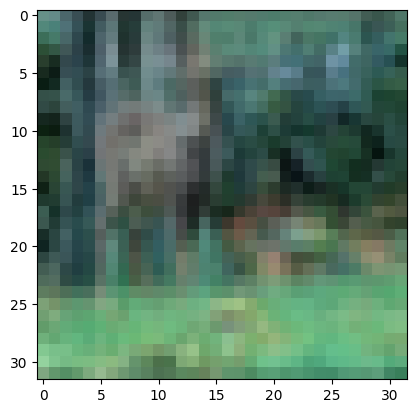

In [ ]:
sample_real_images()

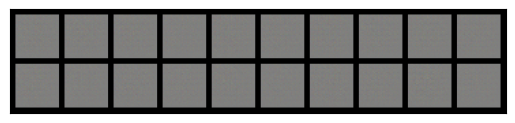

Files already downloaded and verified
training...: 100%|██████████| 500/500 [00:39<00:00, 12.71it/s]
[0/1000]
G_Loss=1.6263 D_Loss=1.0330
Discriminator Acc. (R)=0.6811 (F)=0.6544
Classification Acc. (R)=0.1550 (F)=0.1060
training...: 100%|██████████| 500/500 [00:38<00:00, 12.95it/s]
[1/1000]
G_Loss=0.7595 D_Loss=1.1339
Discriminator Acc. (R)=0.5770 (F)=0.5484
Classification Acc. (R)=0.2021 (F)=0.1872
training...: 100%|██████████| 500/500 [00:37<00:00, 13.20it/s]
[2/1000]
G_Loss=0.8496 D_Loss=0.8909
Discriminator Acc. (R)=0.6311 (F)=0.6242
Classification Acc. (R)=0.1120 (F)=0.3506
training...: 100%|██████████| 500/500 [00:39<00:00, 12.76it/s]
[3/1000]
G_Loss=1.1435 D_Loss=0.6177
Discriminator Acc. (R)=0.6828 (F)=0.6995
Classification Acc. (R)=0.1010 (F)=0.4689
training...: 100%|██████████| 500/500 [00:38<00:00, 12.82it/s]
[4/1000]
G_Loss=0.7052 D_Loss=0.6978
Discriminator Acc. (R)=0.6267 (F)=0.6258
Classification Acc. (R)=0.1095 (F)=0.5328
training...: 100%|██████████| 500/500 [00:37<00

KeyboardInterrupt: ignored

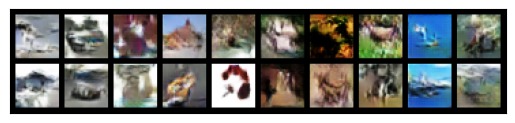

In [ ]:
LOAD_FROM_PATH = False

G_PATH, D_PATH = "G.pth", "D.pth"

netG = Generator()
netD = Discriminator()
start_epoch = 0
if LOAD_FROM_PATH:
  G_dict = torch.load(G_PATH)
  D_dict = torch.load(D_PATH)
  netG.load_state_dict(G_dict['state_dict'])
  netD.load_state_dict(D_dict['state_dict'])
  start_epoch = G_dict['epoch']
  print("Starting from epoch", start_epoch)

netG.to(device)
netD.to(device)

sample_images(netG)

dis_criterion = nn.BCELoss().to(device)
class_criterion = nn.NLLLoss().to(device)

optimizer_G = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))

dataloader = get_data()

D_acc_real, D_acc_fake, D_loss, G_loss = [], [], [], []
D_c_acc_real, D_c_acc_fake = [], []

EPOCHS = 1000
for epoch in range(start_epoch, EPOCHS):
  D_acc_real_temp, D_acc_fake_temp, D_loss_temp, G_loss_temp = [], [], [], []
  D_c_acc_real_temp, D_c_acc_fake_temp = [], []

  for real_Xs, real_ys in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
  # for real_Xs, real_ys in dataloader:
    # TRAIN DISCRIMINATOR
    netD.train()
    netD.zero_grad()

    real_Xs = real_Xs.to(device)
    real_ys = real_ys.to(device)

    # D on real data
    dis_prediction, class_prediction = netD(real_Xs)
    dis_labels = torch.full((100, ), REAL, requires_grad=True).to(device)
    loss_R = dis_criterion(dis_prediction, dis_labels) + class_criterion(class_prediction, real_ys)
    loss_R.backward()

    D_acc_real_temp.append(get_dis_accuracies(dis_labels, dis_prediction))
    D_c_acc_real_temp.append(get_class_accuracies(real_ys, class_prediction))

    # Generate fake data
    fake_seeding, fake_labels = create_random_seeding()
    fake_seeding = fake_seeding.to(device)
    fake_labels = fake_labels.to(device)
    fake_Xs = netG(fake_seeding)
    fake_Xs = fake_Xs.to(device)

    # D on fake data
    dis_prediction, class_prediction = netD(fake_Xs.detach())
    dis_labels = torch.full((100, ), FAKE, requires_grad=True).to(device)
    loss_F = class_criterion(class_prediction, fake_labels) + dis_criterion(dis_prediction, dis_labels)
    loss_F.backward()

    D_acc_fake_temp.append(get_dis_accuracies(dis_labels, dis_prediction))
    D_c_acc_fake_temp.append(get_class_accuracies(fake_labels, class_prediction))

    loss_D = loss_R + loss_F
    optimizer_D.step()
    netD.zero_grad()

    D_loss_temp.append(loss_D.item())
    # TRAIN GENERATOR
    netG.train()
    netG.zero_grad()

    dis_prediction, class_prediction = netD(fake_Xs)
    dis_labels = torch.full((100, ), REAL, requires_grad=True).to(device)

    loss_G = class_criterion(class_prediction, fake_labels) + dis_criterion(dis_prediction, dis_labels)
    loss_G.backward()
    optimizer_G.step()

    G_loss_temp.append(loss_G.item())

  num_batches = len(G_loss_temp)

  avg_D_acc_real = sum(D_acc_real_temp) / num_batches
  avg_D_c_acc_real = sum(D_c_acc_real_temp) / num_batches
  avg_D_acc_fake = sum(D_acc_fake_temp) / num_batches
  avg_D_c_acc_fake = sum(D_c_acc_fake_temp) / num_batches
  avg_D_loss = sum(D_loss_temp) / num_batches
  avg_G_loss = sum(G_loss_temp) / num_batches

  D_acc_real.append(avg_D_acc_real)
  D_acc_fake.append(avg_D_acc_fake)
  D_c_acc_real.append(avg_D_c_acc_real)
  D_c_acc_fake.append(avg_D_c_acc_fake)
  D_loss.append(avg_D_loss)
  G_loss.append(avg_G_loss)

  if epoch % 1 == 0:
    print("[%d/%d]\nG_Loss=%.4f D_Loss=%.4f\nDiscriminator Acc. (R)=%.4f (F)=%.4f\nClassification Acc. (R)=%.4f (F)=%.4f"
          % (epoch, EPOCHS, avg_G_loss, avg_D_loss, avg_D_acc_real, avg_D_acc_fake, avg_D_c_acc_real, avg_D_c_acc_fake))
  if epoch % 5 == 0:
    save_model_state(netG, epoch, f"G_{epoch}.pth")
  if epoch % 15 == 0:
    save_model_state(netD, epoch, f"D_{epoch}.pth")

  sample_images(netG, save=True, epoch=epoch)




In [ ]:
print(len(D_loss))

In [ ]:
!pwd

/content


In [ ]:
!zip -r content.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 25%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.12.11/ (stored 0%)
  adding: content/.config/logs/2023.12.11/14.25.07.026924.log (deflated 86%)
  adding: content/.config/logs/2023.12.11/14.25.16.062420.log (deflated 58%)
  adding: content/.config/logs/2023.12.11/14.24.56.854213.log (deflated 58%)
  adding: content/.config/logs/2023.12.11/14.25.26.231373.log (deflated 57%)
  adding: content/.config/logs/2023.12.11/14.24.28.856891.log (deflated 91%)
  adding: content/.config/logs/202

In [ ]:
# from google.colab import files
# files.download('content.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# !cp content.zip /content/drive/MyDrive/